In [1]:
main_path='/content/drive/MyDrive/deep learning'
train_data_path=main_path+'/Google_Stock_Price_Train.xls'
test_data_path=main_path+'/Google_Stock_Price_Test.xls'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Libraries Load

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Data processing and cleaning

In [4]:
train_data=pd.read_csv(train_data_path)
test_data=pd.read_csv(test_data_path)

In [5]:
train_data.head(2)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [8]:
train_data['Date'],test_data["Date"]=pd.to_datetime(train_data['Date']),pd.to_datetime(test_data['Date'])

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   object        
 5   Volume  1258 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 59.1+ KB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    20 non-null     datetime64[ns]
 1   Open    20 non-null     float64       
 2   High    20 non-null     float64       
 3   Low     20 non-null     float64       
 4   Close   20 non-null     float64       
 5   Volume  20 non-null     object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.1+ KB


In [12]:
#there is issue with volumne data having , in its string
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)
train_data['Close']=train_data['Close'].str.replace(",",'').astype(float)


train_data['Volume'] = pd.to_numeric(train_data['Volume'])
test_data['Volume'] = pd.to_numeric(test_data['Volume'])

In [13]:
train_data['Volume'].isna().sum()
test_data['Volume'].isna().sum()

0

In [14]:
train_data.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


Scaling used MInMax to bring all the price in same level and ultimately between 0-1

In [15]:
test_data.head(3)

,Date,Open,High,Low,Close,Volume
0,2017-01-03,778.81,789.63,775.80,786.14,1657300.0
1,2017-01-04,788.36,791.34,783.16,786.90,1073000.0
2,2017-01-05,786.08,794.48,785.02,794.02,1335200.0


In [16]:
train_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 59.1 KB


In [18]:
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']
# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data[features_to_scale])

source:https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [ ]:
def convert_data_into_array_of_days(input_data, N, M):
    X, y = [], []
    for i in range(len(input_data) - N - M + 1):
        # Append the sequences for N number of days
        X.append(input_data[i:i+N])  # N timesteps
        # Append the target values (next M days rest of all 5 features)
        y.append(input_data[i+N:i+N+M])  # M timesteps
    return np.array(X), np.array(y)

# Example usage
N, M = 30, 1  # 30 days input and  1 day prediction
X_array, y_array = convert_data_into_array_of_days(scaled_train, N, M)
print(f"X shape: {X_array.shape}")  # (samples, 30, 5)
print(f"y shape: {y_array.shape}")  

X shape: (1228, 30, 5)
y shape: (1228, 1, 5)


In [20]:
X_array.shape,y_array.shape

((1228, 30, 5), (1228, 1, 5))

Split main train data to create validation set

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

In [22]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((982, 30, 5), (246, 30, 5), (982, 1, 5), (246, 1, 5))

In [23]:
print("y_val scaled min-max:", y_val.min(), y_val.max())


y_val scaled min-max: 0.0 0.9993938475526597


Train the LSTM model to predict opening price

In [24]:
X_train.shape[1],X_train.shape[2],y_val.shape

(30, 5, (246, 1, 5))

In [30]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=5))  # Predict the Open, High, Low, Close, Volume of stock
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


In [31]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,855 (202.56 KB)

 Trainable params: 51,855 (202.56 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model_checkpoints=ModelCheckpoint(
    filepath=main_path+'/lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [33]:
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

In [34]:
history = lstm_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32,
    callbacks=[model_checkpoints, early_stopping]
)

Epoch 1/2000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1092
Epoch 1: val_loss improved from inf to 0.06297, saving model to /content/drive/MyDrive/deep learning/lstm_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 0.1084 - val_loss: 0.0630
Epoch 2/2000
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0635
Epoch 2: val_loss improved from 0.06297 to 0.06085, saving model to /content/drive/MyDrive/deep learning/lstm_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0635 - val_loss: 0.0609
Epoch 3/2000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0621
Epoch 3: val_loss improved from 0.06085 to 0.06025, saving model to /content/drive/MyDrive/deep learning/lstm_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0621 - val_loss: 0.0602
Epoch 4/2000
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0649
Epoch 4: val_loss did not improve from 0.06025
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0648 - val_loss: 0.0611
Epoch 5/2000
31/31 ━━━

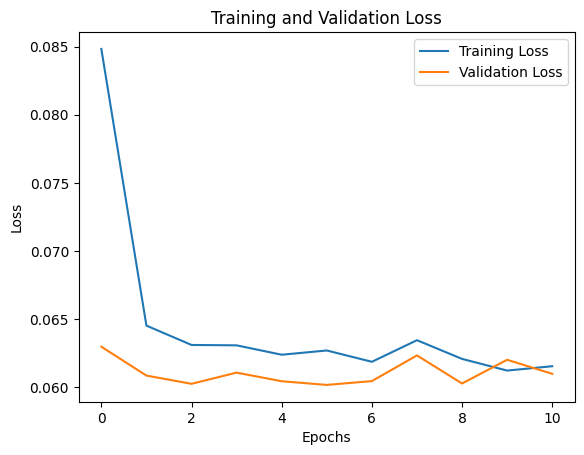

In [35]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [67]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [70]:


best_model = load_model(main_path+'/lstm_model.keras')

In [69]:
X_val.shape,y_val.shape

((246, 30, 5), (246, 1, 5))

In [71]:
y_pred_scaled = best_model.predict(X_val)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [74]:
y_pred_scaled.shape

(246, 5)

In [75]:
y_val_scaled = y_val.squeeze()  # Shape: (246, 5)

# Verify shapes match
print("y_pred_scaled shape:", y_pred_scaled.shape)
print("y_val_scaled shape:", y_val_scaled.shape)

y_pred_scaled shape: (246, 5)
y_val_scaled shape: (246, 5)


In [79]:
y_val_scaled.max(),y_val_scaled.min()

(0.9993938475526597, 0.0)

In [81]:
y_pred_scaled.max(),y_pred_scaled.min()

(0.51565814, 0.1234016)

In [76]:
# Inverse transform predictions
y_pred_original = scaler.inverse_transform(y_pred_scaled)

# Inverse transform actual values
y_val_original = scaler.inverse_transform(y_val_scaled)

# Check first few predictions and actual values
print("First 5 Predicted Values (Original Scale):", y_pred_original[:5])
print("First 5 Actual Values (Original Scale):", y_val_original[:5])

First 5 Predicted Values (Original Scale): [[5.3152509e+02 5.3703564e+02 5.3469513e+02 7.1386682e+02 3.1314470e+06]
 [5.4031042e+02 5.4510492e+02 5.4237317e+02 7.3181464e+02 3.1800732e+06]
 [5.3168842e+02 5.3706543e+02 5.3444800e+02 7.2154694e+02 3.1931012e+06]
 [5.3864294e+02 5.4412146e+02 5.4202582e+02 7.1994611e+02 3.2025462e+06]
 [5.4514703e+02 5.5029596e+02 5.4657257e+02 7.2548383e+02 3.1928210e+06]]
First 5 Actual Values (Original Scale): [[5.26350e+02 5.32460e+02 5.25660e+02 5.26890e+02 1.61080e+06]
 [5.77830e+02 5.79070e+02 5.75030e+02 1.15692e+03 3.91270e+06]
 [3.78120e+02 3.85040e+02 3.77830e+02 7.68060e+02 4.17170e+06]
 [5.15760e+02 5.17180e+02 5.01420e+02 5.15730e+02 3.33550e+06]
 [7.77850e+02 7.81810e+02 7.74970e+02 7.81560e+02 1.10980e+06]]


In [77]:
mse_val = mean_squared_error(y_val_original, y_pred_original)
mae_val = mean_absolute_error(y_val_original, y_pred_original)

print(f"Validation MSE: {mse_val}")
print(f"Validation MAE: {mae_val}")

Validation MSE: 819070435813.6274
Validation MAE: 307849.14702354267


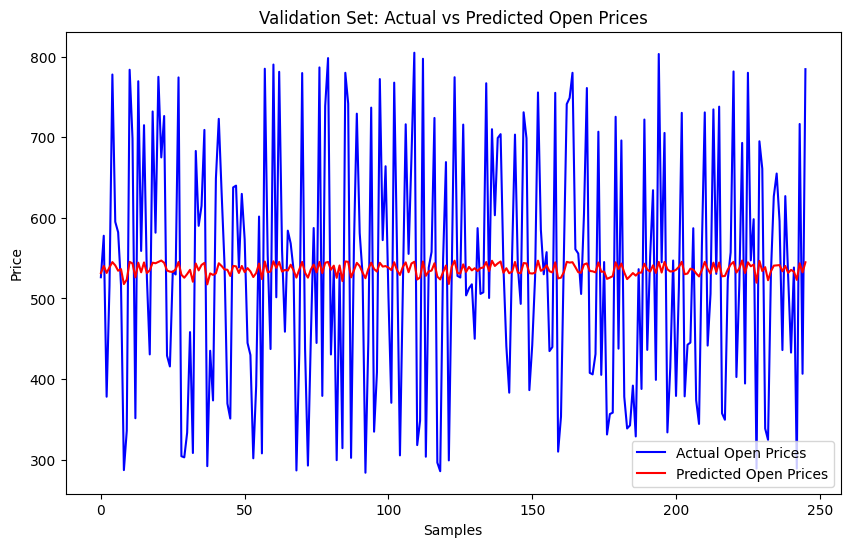

In [85]:
# Plot actual vs predicted for 'Open' price (feature index 0)
plt.figure(figsize=(10, 6))
plt.plot(y_val_original[:, 0], label="Actual Open Prices", color='blue')
plt.plot(y_pred_original[:, 0], label="Predicted Open Prices", color='red')
plt.title("Validation Set: Actual vs Predicted Open Prices")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.show()

Test model on testing set/hidden data

In [86]:
# Scale the test data
scaled_test = scaler.transform(test_data
 [['Open', 'High', 'Low', 'Close', 'Volume']])


In [88]:
train_data.shape,test_data.shape

((1258, 6), (20, 6))

In [89]:
scaled_test.shape

(20, 5)

In [87]:
# Convert test data into input/output sequences
N, M = 30, 1
X_test, y_test = convert_data_into_array_of_days(scaled_test, N, M)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (0,)
y_test shape: (0,)


In [90]:
N, M = 10, 1
X_test, y_test = convert_data_into_array_of_days(scaled_test, N, M)

# Check shapes
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (10, 10, 5)
y_test shape: (10, 1, 5)


In [91]:
y_pred_scaled_test = best_model.predict(X_test)

# Check the shape of predictions
print("y_pred_scaled_test shape:", y_pred_scaled_test.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
y_pred_scaled_test shape: (10, 5)


In [92]:
y_test_scaled = y_test.squeeze()  # Shape: (samples, 5)

# Inverse transform predictions
y_pred_original_test = scaler.inverse_transform(y_pred_scaled_test)

# Inverse transform actual values
y_test_original = scaler.inverse_transform(y_test_scaled)

# Check first few predictions and actual values
print("First 5 Predicted Test Values (Original Scale):", y_pred_original_test[:5])
print("First 5 Actual Test Values (Original Scale):", y_test_original[:5])

First 5 Predicted Test Values (Original Scale): [[4.9447818e+02 4.9999167e+02 4.7546341e+02 6.6341809e+02 2.4193508e+06]
 [4.9463400e+02 5.0016660e+02 4.7560135e+02 6.6355676e+02 2.4198625e+06]
 [4.9491354e+02 5.0046246e+02 4.7591306e+02 6.6383331e+02 2.4225728e+06]
 [4.9510858e+02 5.0067841e+02 4.7613101e+02 6.6402100e+02 2.4242330e+06]
 [4.9508734e+02 5.0065912e+02 4.7609357e+02 6.6398401e+02 2.4236048e+06]]
First 5 Actual Test Values (Original Scale): [[8.0581e+02 8.0621e+02 8.0099e+02 8.0607e+02 1.2944e+06]
 [8.0512e+02 8.0948e+02 8.0180e+02 8.0217e+02 9.1930e+05]
 [8.0691e+02 8.0691e+02 8.0169e+02 8.0502e+02 1.6700e+06]
 [8.0725e+02 8.2087e+02 8.0374e+02 8.1931e+02 1.9636e+06]
 [8.2230e+02 8.2590e+02 8.1782e+02 8.2387e+02 1.4740e+06]]


In [93]:
mse_test = mean_squared_error(y_test_original, y_pred_original_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test_original, y_pred_original_test)

print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")

Test MSE: 147891345630.86172
Test RMSE: 384566.43851337535
Test MAE: 158118.87843996583


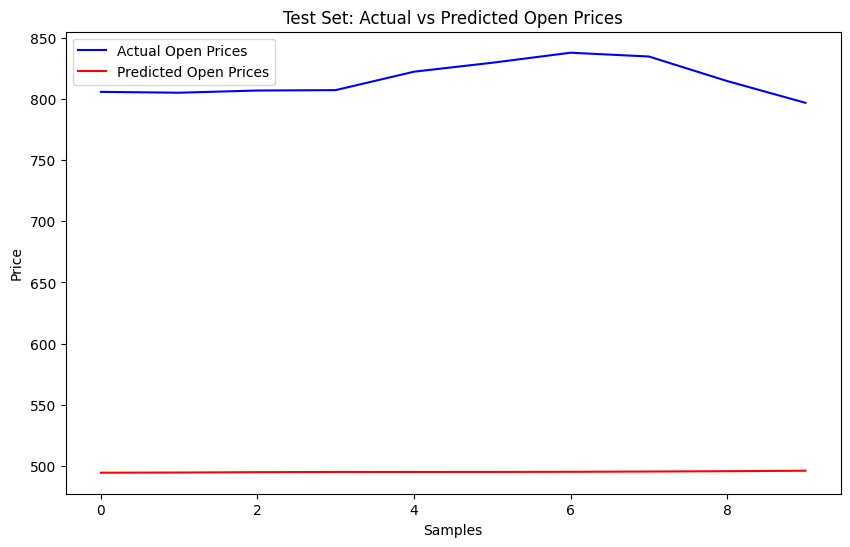

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:, 0], label="Actual Open Prices", color='blue')  # Open prices
plt.plot(y_pred_original_test[:, 0], label="Predicted Open Prices", color='red')
plt.title("Test Set: Actual vs Predicted Open Prices")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.show()